In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from mlp import nn, optim, Graph
from mlp.tensor import Tensor, ones, zeros

In [2]:
BATCH_SIZE = 512

In [3]:
data = pd.read_csv(
    "../Flu Shot Learning Predict H1N1 and Seasonal Flu Vaccines/fixed_training_set.csv"
)
data = data.drop(columns=["respondent_id"])

training_dataset = np.array(data)


# 加载数据集
def load_data(data: np.ndarray, batch_size, shuffle=True):
    data = data[: (data.shape[0] // batch_size) * batch_size]
    if shuffle:
        print("Shuffling data")
        np.random.shuffle(data)
    for i in range(batch_size, data.shape[0] + 1, batch_size):
        yield Tensor(np.array(data[i - batch_size : i, :-2], dtype=np.float64)), Tensor(
            np.array(data[i - batch_size : i, -2:], dtype=np.float64)
        )

In [4]:
class Model(nn.Module):
    def __init__(self, in_feature, hidden_feature=32, out_feature=1) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_feature, hidden_feature),
            nn.ReLU(),
            nn.Linear(hidden_feature, out_feature),
            nn.Sigmoid(),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.network(x)
        return x


def draw_loss(train_loss):
    plt.plot(
        np.arange(len(train_loss)),
        train_loss,
        color=np.random.rand(
            3,
        ),
        label="train loss",
    )
    plt.legend(loc=0, ncol=1)
    plt.xlabel("iternations")
    plt.ylabel("loss")
    # plt.show()


# Calculate Accuracy
def accuracy(real_val, predict_val):
    assert len(real_val) == len(predict_val)
    correct = [1 if x == y else 0 for (x, y) in zip(real_val, predict_val)]
    return np.sum(correct) / len(real_val)

In [5]:
def train(model: Model, data, threshold, lr):
    train_loss = []
    criterion = nn.BinaryCrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
    model.train()
    for epoch in range(threshold):
        loss_epoch = 0

        for id, (x, y) in enumerate(load_data(data, BATCH_SIZE)):
            y_pred = model(x)
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            loss_epoch += loss.item()
            optimizer.step()
        loss_epoch /= len(data)
        print(f"Epoch: {epoch}, Loss: {loss_epoch}")
        train_loss.append(loss_epoch)

    # loss curve
    draw_loss(train_loss)

Shuffling data
Epoch: 0, Loss: 0.001156198324095916
Shuffling data
Epoch: 1, Loss: 0.0010019283677500286
Shuffling data
Epoch: 2, Loss: 0.0009073762274227056
Shuffling data
Epoch: 3, Loss: 0.0008587538273849098
Shuffling data
Epoch: 4, Loss: 0.0008355003473123539
Shuffling data
Epoch: 5, Loss: 0.0008216601792005419
Shuffling data
Epoch: 6, Loss: 0.0008138484119622482
Shuffling data
Epoch: 7, Loss: 0.0008087766606978691
Shuffling data
Epoch: 8, Loss: 0.000805574411029349
Shuffling data
Epoch: 9, Loss: 0.0008028423004099045
Shuffling data
Epoch: 10, Loss: 0.000800180102580024
Shuffling data
Epoch: 11, Loss: 0.0007986551426214995
Shuffling data
Epoch: 12, Loss: 0.000797441412712469
Shuffling data
Epoch: 13, Loss: 0.0007963290227520911
Shuffling data
Epoch: 14, Loss: 0.0007951226689135014
Shuffling data
Epoch: 15, Loss: 0.0007946457216134241
Shuffling data
Epoch: 16, Loss: 0.0007939540569285223
Shuffling data
Epoch: 17, Loss: 0.0007925663331779672
Shuffling data
Epoch: 18, Loss: 0.00079258

[(0.8656684517580756, 0.8649458278748897),
 (0.8665370712452526, 0.8529726795199107),
 (0.8664812329083542, 0.8532387686141292),
 (0.8632532816229117, 0.8598649121026578),
 (0.8652979422486163, 0.8567203730945914),
 (0.8631059890090657, 0.8461252225291069),
 (0.8585588475012275, 0.8627174320546003),
 (0.8647214183289905, 0.8533674075714741),
 (0.8494633704444579, 0.8484334778838794),
 (0.854230993755587, 0.8578499260198689)]

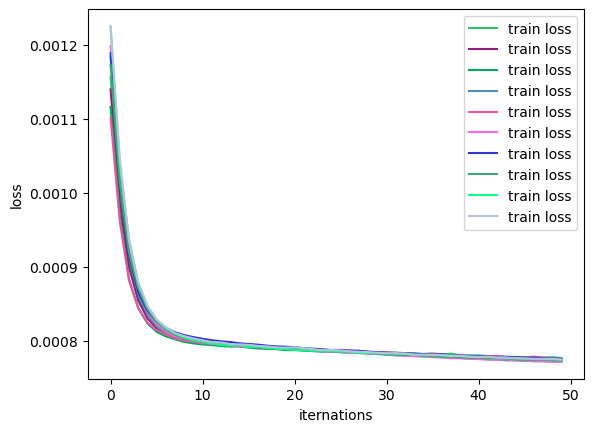

In [6]:
from sklearn.metrics import roc_auc_score

kf = KFold(n_splits=10, shuffle=True)

roc_list = []

for train_set, valid_set in kf.split(training_dataset):
    train_data = training_dataset[train_set]
    model = Model(in_feature=train_data.shape[1] - 2, out_feature=2)
    train(model, train_data, 50, lr=0.001)

    valid_data = training_dataset[valid_set]
    # model.eval()
    y_pred = model(Tensor(valid_data[:, :-2], dtype=np.float64))
    roc_list.append(
        (
            roc_auc_score(valid_data[:, -2], y_pred.data[:, -2]),
            roc_auc_score(valid_data[:, -1], y_pred.data[:, -1]),
        )
    )
    Graph.clear()
    # y_pred = np.array([1 if x.data.item() > 0.5 else 0 for x in y_pred])
    # accuracy_list.append(accuracy(valid_data[:, -1], y_pred))
    # break

roc_list

#### 预测测试集

Shuffling data
Epoch: 0, Loss: 0.0011910382473919311
Shuffling data
Epoch: 1, Loss: 0.0010496847868321107
Shuffling data
Epoch: 2, Loss: 0.0009455162345339166
Shuffling data
Epoch: 3, Loss: 0.0008771297777851937
Shuffling data
Epoch: 4, Loss: 0.0008402055765169325
Shuffling data
Epoch: 5, Loss: 0.0008210282984851994
Shuffling data
Epoch: 6, Loss: 0.000811509085968718
Shuffling data
Epoch: 7, Loss: 0.0008047146138763521
Shuffling data
Epoch: 8, Loss: 0.0008012030458281944
Shuffling data
Epoch: 9, Loss: 0.0007986526945989336
Shuffling data
Epoch: 10, Loss: 0.0007967201245682608
Shuffling data
Epoch: 11, Loss: 0.0007952442327164892
Shuffling data
Epoch: 12, Loss: 0.000794333695080674
Shuffling data
Epoch: 13, Loss: 0.0007932718593335931
Shuffling data
Epoch: 14, Loss: 0.000791868464858722
Shuffling data
Epoch: 15, Loss: 0.0007905642792478264
Shuffling data
Epoch: 16, Loss: 0.0007917151602805938
Shuffling data
Epoch: 17, Loss: 0.000789389282625737
Shuffling data
Epoch: 18, Loss: 0.00078871

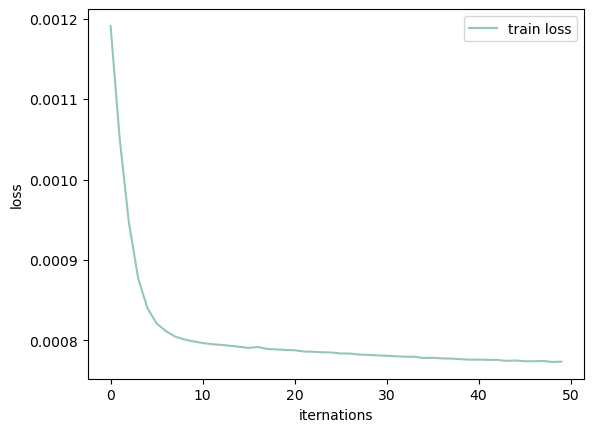

In [7]:
test_dataset = pd.read_csv(
    "../Flu Shot Learning Predict H1N1 and Seasonal Flu Vaccines/fixed_test_set.csv"
)

id_start = test_dataset["respondent_id"][0]

for id, item in enumerate(test_dataset["respondent_id"]):
    assert id + id_start == item

test_dataset = test_dataset.drop(columns=["respondent_id"])
test_dataset = np.array(test_dataset, dtype=np.float32)

model = Model(training_dataset.shape[1] - 2, out_feature=2)
train(model, train_data, 50, lr=0.001)

y_pred = model(Tensor(test_dataset))
y_pred = pd.DataFrame(
    {
        "respondent_id": np.arange(id_start, id_start + y_pred.shape[0]),
        "h1n1_vaccine": y_pred.data[:, -2],
        "seasonal_vaccine": y_pred.data[:, -1],
    }
)
y_pred.to_csv("submission.csv", index=False)

Graph.clear()